In [1]:
import gcdyn.cycles
from gcdyn.cycles import (
    GC,
    cell_div_balanced_proliferator,
    simple_proliferator,
    binary_proliferator,
)
from gcdyn.phenotype import DMSPhenotype
from gcdyn.fitness import Fitness
from IPython.display import display
from Bio import SeqIO

In [2]:
fasta_path = "gcreplay_samples/five_seqs.fasta"
seqs = [
    str(seq_record.seq)
    for seq_record in SeqIO.parse(fasta_path, "fasta")
    if seq_record.id != "naive"
]

Trees with balanced proliferator, uniform mutator, dms selector

0    1.063396
Name: delta_log10_KD, dtype: float32
0    -0.184232
1     1.063396
2     0.110300
3     1.063396
4     0.423596
5     1.063396
6     0.366404
7     1.063396
8     1.063396
9    -0.240262
10    1.063396
11    1.063396
Name: delta_log10_KD, dtype: float32
0     1.139097
1     1.063396
2     1.095261
3     0.389370
4     1.089497
5     0.373602
6    -0.670769
7     1.194458
8    -0.240262
9     0.110300
10    0.883301
11   -0.075116
Name: delta_log10_KD, dtype: float32
0    1.322244
Name: delta_log10_KD, dtype: float32
0     1.443075
1     1.443075
2     1.322244
3     1.322244
4     1.322244
5     1.443075
6     1.461870
7     1.322244
8     1.322244
9     1.322244
10    1.322244
11    1.322244
Name: delta_log10_KD, dtype: float32
0     0.864266
1    -0.001807
2     1.322244
3     1.322244
4     1.322244
5     0.015248
6     0.500706
7     1.322244
8     1.322244
9     1.444861
10    1.443075
11    0.932225
Name: delta_log10_KD, dtype: float32
0    0.92829
Name: delta_log10

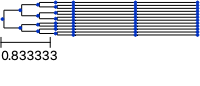

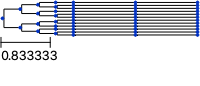

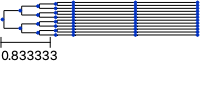

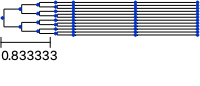

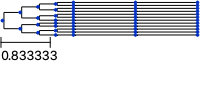

In [3]:
tree_renders = []
dms_cell_div_selector = gcdyn.cycles.DMSSelector(slope=3.7, y_intercept=0)
uniform_mutator = gcdyn.cycles.UniformMutator()

for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        dms_cell_div_selector,
        N0=1,
        Nmax=50,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with balanced proliferator, hotspot-aware mutator, dms selector

0    1.063396
Name: delta_log10_KD, dtype: float32
0     1.063396
1     0.400933
2     0.470879
3     1.168438
4     1.076776
5     1.063396
6     1.168437
7     0.561165
8     1.582454
9     0.470879
10    1.095261
11    1.063396
Name: delta_log10_KD, dtype: float32
0     1.063396
1     0.702965
2     0.400933
3     1.063396
4     0.470879
5     1.095261
6     0.622319
7    -0.058766
8     1.171376
9     1.076776
10    0.531420
11    1.168438
Name: delta_log10_KD, dtype: float32
0    -1.339761
1    -1.466646
2     0.432799
3     1.168438
4     0.544800
5    -0.699699
6     1.029040
7     0.702965
8     0.470879
9     1.249968
10    0.400933
11   -0.541830
Name: delta_log10_KD, dtype: float32
0    -3.360482
1    -1.339761
2    -0.699699
3     1.116981
4     1.029040
5     0.470879
6    -0.295255
7     1.249968
8     1.146832
9     0.432799
10   -0.541830
11    0.400933
Name: delta_log10_KD, dtype: float32
0    1.322244
Name: delta_log10_KD, dtype: float32
0     1.107337
1     1.387681


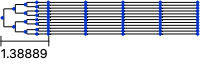

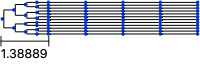

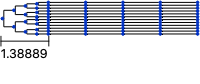

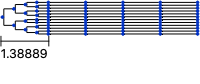

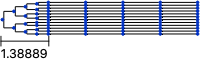

In [4]:
tree_renders = []
dms_cell_div_selector = gcdyn.cycles.DMSSelector(slope=3.7, y_intercept=0)
fivemer_mutator = gcdyn.cycles.FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        fivemer_mutator,
        dms_cell_div_selector,
        N0=1,
        Nmax=35,
    )
    gc.simulate(5, enforce_timescale=True, competition=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

 Trees with balanced proliferator, uniform mutator, uniform selector

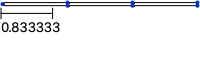

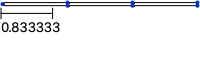

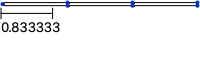

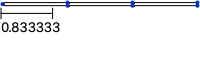

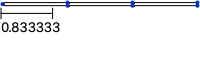

In [5]:
tree_renders = []
uniform_selector = gcdyn.cycles.UniformSelector()
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        cell_div_balanced_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=True)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Trees with simple proliferator, uniform mutator, dms selector

0    1.063396
Name: delta_log10_KD, dtype: float32
0    0.976568
1    1.062787
2   -0.566316
3    0.976568
Name: delta_log10_KD, dtype: float32
0   -1.322075
1   -0.639119
2   -2.335097
3    0.356365
4    1.199772
5    0.732764
6    0.911551
7    0.740566
Name: delta_log10_KD, dtype: float32


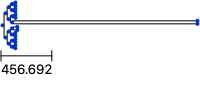

In [6]:
tree_renders = []
dms_selector = gcdyn.cycles.DMSSelector(slope=2, y_intercept=0)
for i in range(1):
    seq = seqs[i]
    gc = GC(
        seq,
        simple_proliferator,
        uniform_mutator,
        dms_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Binary proliferator, uniform mutator, uniform selector

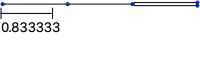

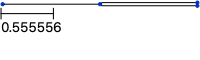

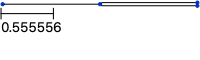

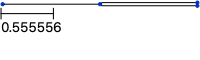

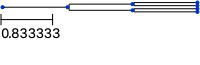

In [7]:
tree_renders = []
for i in range(len(seqs)):
    seq = seqs[i]
    gc = GC(
        seq,
        binary_proliferator,
        uniform_mutator,
        uniform_selector,
        N0=1,
    )
    gc.simulate(3, enforce_timescale=False)
    tree_renders.append(gc.tree.render("%%inline", w=200))

for render in tree_renders:
    display(render)

Look at phenotype trajectory for a simulation of a single cell in a GC

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
from matplotlib.colors import SymLogNorm
from ete3 import faces, AttrFace, TreeStyle, NodeStyle, CircleFace

selector = gcdyn.cycles.DMSSelector(slope=3.7, y_intercept=0)

seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTATATAAGCTACAGTGGTACCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGCATTCTGTGACTGCTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACAAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCGTACAGATACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAACAATATAACAACTATCCTCTCACGTTCGGCTCGGGGACTAACCTAGAAATAAAA"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    fivemer_mutator,
    selector,
    N0=1,
    Nmax=50,
)
gc.simulate(6, enforce_timescale=True, prune=False)
sequences = []
for node in gc.tree.traverse():
    sequences.append(node.sequence)
phenotype = DMSPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "Linear.model",
    ["delta_log10_KD", "delta_expression"],
    -10.43,
)
kd_vals = phenotype.calculate_KD(sequences)
seq_to_kd = dict(zip(sequences, kd_vals))

0    1.465005
Name: delta_log10_KD, dtype: float32
0     0.994295
1     1.465005
2     1.508933
3     1.465005
4     1.426416
5     1.465005
6     1.465005
7     1.610031
8     1.400315
9     1.400315
10    1.018355
11    1.465005
Name: delta_log10_KD, dtype: float32
0     1.682647
1     1.447252
2     1.018355
3     1.610031
4     1.407123
5     1.465005
6     1.508933
7     0.994295
8     1.430428
9     1.465005
10    1.601070
11    0.166527
Name: delta_log10_KD, dtype: float32
0     1.447252
1     1.251036
2     0.120575
3     1.601070
4     1.452777
5     1.465005
6     1.362977
7     1.727810
8     0.315766
9     1.450676
10    0.994295
11    1.700887
Name: delta_log10_KD, dtype: float32
0     1.452777
1     1.600471
2    -1.123956
3     0.123711
4     0.315766
5     1.362977
6    -0.735551
7     1.450676
8     1.727810
9     1.251036
10    0.994295
11    1.601070
Name: delta_log10_KD, dtype: float32
0    -0.696451
1     1.814726
2     0.994295
3     1.450676
4     1.389269
5     

In [9]:
def layout_KD(node):
    node.KD = seq_to_kd[node.sequence]
    if node.is_leaf() or node.is_root():
        faces.add_face_to_node(AttrFace("KD"), node, column=0)
    if node.terminated:
        node.set_style(terminated_style)


terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"
ts = TreeStyle()
ts.layout_fn = layout_KD
#gc.tree.render("%%inline", w=300, tree_style=ts)

In [10]:
selector = gcdyn.cycles.DMSSelector(fitness_method=Fitness.linear_fitness, slope=5, y_intercept=.8)
fivemer_mutator = gcdyn.cycles.FivemerMutator(
    mutability_csv="MK_RS5NF_mutability.csv",
    substitution_csv="MK_RS5NF_substitution.csv",
)

seq = "GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTATATAAGCTACAGTGGTACCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGCATTCTGTGACTGCTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACAAATGTAGGCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCGTACAGATACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAACAATATAACAACTATCCTCTCACGTTCGGCTCGGGGACTAACCTAGAAATAAAA"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    fivemer_mutator,
    selector,
    N0=1,
    Nmax=200,
)
gc.simulate(3, enforce_timescale=True, prune=False)
sequences = []
for node in gc.tree.traverse():
    sequences.append(node.sequence)
phenotype = DMSPhenotype(
    1,
    1,
    336,
    "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv",
    "Linear.model",
    ["delta_log10_KD", "delta_expression"],
    -10.43,
)
kd_vals = phenotype.calculate_KD(sequences)
seq_to_kd = dict(zip(sequences, kd_vals))

0    1.465005
Name: delta_log10_KD, dtype: float32
0     1.465005
1     1.805271
2     1.465005
3     1.485862
4     1.805271
5     1.465005
6     1.465005
7     1.465005
8     1.485862
9     1.805271
10    1.835009
11    1.465005
12    1.485862
13    1.465005
14   -0.901912
15    1.465005
16    1.465005
17    1.465005
18    1.465005
19    1.805271
20    1.465005
21    1.808735
22    1.465005
23    1.485862
24    1.465005
25    1.465005
26    1.835009
27    1.465005
28    1.835009
29    1.465005
30    1.485862
31    1.465005
32   -0.482985
33    2.286910
34    1.806015
35    1.485862
36    1.465005
37    1.465005
38    1.485862
39    1.465005
40    1.805271
41   -0.482985
42    1.465005
43    1.465005
44    1.131370
45    1.131370
46    1.247858
47    1.485862
48    0.546352
49    1.795991
50    0.749280
51    1.485862
52    1.835009
53    1.443399
54    1.465005
Name: delta_log10_KD, dtype: float32
0     1.795991
1     1.465005
2     1.835009
3     1.485862
4     1.913108
5     1.4858

In [11]:
from ete3 import faces, AttrFace, TreeStyle, NodeStyle, CircleFace
def layout_KD(node):
    node.KD = seq_to_kd[node.sequence]
    if node.is_leaf() or node.is_root():
        faces.add_face_to_node(AttrFace("KD"), node, column=0)
    if node.terminated:
        node.set_style(terminated_style)


terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"
ts = TreeStyle()
ts.layout_fn = layout_KD
#gc.tree.render("%%inline", w=300, tree_style=ts)

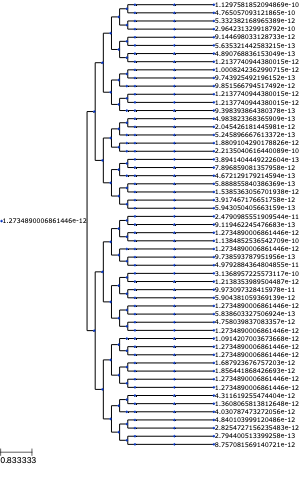

In [12]:
gc.prune()
gc.tree.render("%%inline", w=300, tree_style=ts)

Plotting trajectory of simulated phenotypes in one simulation with three cycles:

/var/folders/qy/y63rpqnw8xn4r6006s6mz6p00000gp/T/ipykernel_58755/1081657697.py:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = SymLogNorm(linthresh=1, vmin=0, vmax=10)


Text(0.5, 0, 'cycle number')

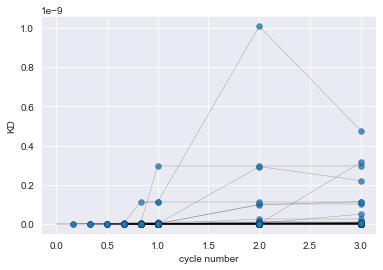

In [13]:
# Adapted from phenotype-trajectories notebook (https://github.com/matsengrp/gcreplay/blob/main/analysis/phenotype-trajectories.ipynb)

points = []
lines = []
colors = []
sim_df = pd.DataFrame()
norm = SymLogNorm(linthresh=1, vmin=0, vmax=10)
cmap = "viridis"

fig, axes = plt.subplots()

alive_descendants = set(
    node for node in gc.tree.get_descendants() if not node.terminated
)

for node in alive_descendants:
    node_phenotype = getattr(node, "KD")
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = getattr(node.up, "KD")
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points),
    cmap=cmap,
    alpha=0.8,
    edgecolors="k",
    linewidths=0.2,
    zorder=4,
    norm=norm
)
axes.set_ylabel("KD")
axes.set_xlabel("cycle number")

0      1.465005
1      1.465005
2      1.465005
3      1.485862
4      1.835009
         ...   
223    0.964610
224    0.885145
225    1.118909
226    2.123711
227    0.627641
Name: delta_log10_KD, Length: 228, dtype: float32


Text(0.5, 0, 'cycle number')

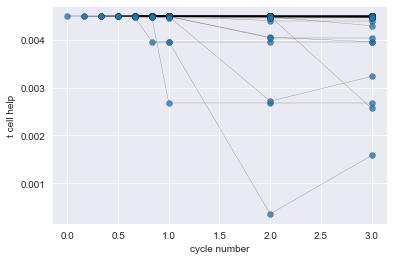

In [14]:
fig, axes = plt.subplots()
points = []
lines = []

fit = Fitness(Fitness.sigmoidal_fitness)
fitness_df = fit.normalized_fitness_df(sequences, calculate_KD=phenotype.calculate_KD)
seq_to_fitness = dict(zip(sequences, fitness_df["normalized_t_cell_help"]))
for node in gc.tree.traverse():
    node_phenotype = seq_to_fitness[node.sequence]
    points.append((gc.tree.get_distance(node), node_phenotype))
    if node.up is not None:
        parent_phenotype = seq_to_fitness[node.up.sequence]
        lines.append(
            [
                (gc.tree.get_distance(node.up), parent_phenotype),
                (gc.tree.get_distance(node), node_phenotype),
            ]
        )
lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
axes.add_collection(lc)
axes.scatter(
    *zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4
)


axes.set_ylabel("t cell help")
axes.set_xlabel("cycle number")

In [15]:


from math import isclose
all_tfh = []
all_is = []
for i in range(1,4):
    seqs = [node.sequence for node in gc.tree.traverse() if isclose(node.get_distance(gc.tree), i)]
    i_vals = [str(i)]*len(seqs)
    fit = Fitness(Fitness.sigmoidal_fitness)
    fitness_df = fit.normalized_fitness_df(seqs, calculate_KD=phenotype.calculate_KD)
    seq_to_fitness = dict(zip(sequences, fitness_df["normalized_t_cell_help"]))
    all_tfh.extend(fitness_df["normalized_t_cell_help"])
    all_is.extend(i_vals)

help_df = pd.DataFrame({"normalized_t_cell_help": all_tfh, "cycle_number": all_is})
print(help_df)

0    -0.482985
1    -0.482985
2     0.749280
3    -0.901912
4     1.485862
5     1.485862
6     2.286910
7     1.485862
8     1.485862
9     1.485862
10    1.485862
11    1.485862
12    1.485862
13    1.485862
14    1.805271
15    1.805271
16    1.805271
17    1.805271
18    1.805271
19    1.835009
20    1.835009
21    1.808735
22    1.835009
23    1.806015
24    1.835009
25    1.795991
26    1.465005
27    1.465005
28    1.465005
29    1.465005
30    1.465005
31    1.465005
32    1.465005
33    1.443399
34    1.465005
35    1.465005
36    1.465005
37    1.465005
38    1.465005
39    1.465005
40    1.465005
41    1.465005
42    1.465005
43    1.465005
44    1.465005
45    1.465005
46    1.465005
47    1.465005
48    1.465005
49    1.465005
50    1.465005
51    1.131370
52    1.131370
53    1.247858
54    0.546352
Name: delta_log10_KD, dtype: float32
0    -0.482985
1    -1.433613
2     0.749280
3    -0.901912
4     0.608831
5     1.725282
6     2.440107
7     1.485862
8     1.485862
9  

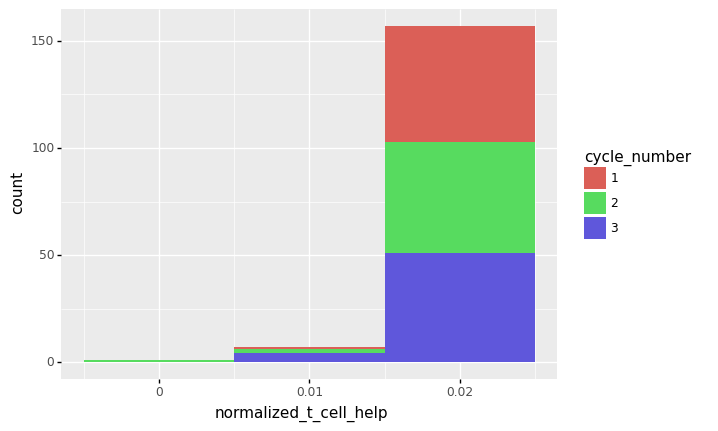

<ggplot: (8769054344828)>

In [16]:
from plotnine import ggplot, aes, geom_histogram, after_stat

(
    ggplot(help_df, aes(x='normalized_t_cell_help', y=after_stat('count'),fill='cycle_number'))
    + geom_histogram(binwidth=0.01)
)

In [17]:
selector = gcdyn.cycles.ThreeNormSelector()
seq = "CAACTAGTTGTAACCTTTTAAAAAATGAATTTCATAATATATGTTATTTCATGTATATGGATAATTTGAATAAATTTAATTTAAGTTTAATCAATTTTTACATAGATTTAAAATTAAAAGCAATGATTTTTCAGGTGCAAAATAAAAATATTAAGTAATTAAAAGAATTATAATATTCTAAATGTTGATCCATTTGAATCATCATCTAGAATTATATCGTTCTAAAAAAAAGATATTAGAAACTCTCTTCTTTAACAATTAGGTCTATGAAAACTACAAAACTAATTTTCCTAGTAACTGAAGAGTAAGAATCTATTATATATAAGAAGATATTTACTCAATAATTAATACTTTAGGTATTTAATTTTTCTTATTGTTTTAAACTGACTTATTTTTTTTGTTTGTAAATCTATAAAATTTATATTAATGTGTAAATATAATTCGAAAAAAAATATCCAGAACCAAAAATAATCAGCATTTTAAATTTTGCTTAATCCACCTACATATTGTTATAATAAATCAGTAGAAATTTAATGTTAAATGATGGAATGTTCTTAATTTTAATAGAAAATTAAAGGAAATATATATACAATATAAAGAAGTTAGAAAATTAACAAGAGAATCTTCTTTCTGTTTATTAAAGAATGAATATAAAAT"
gc = GC(
    seq,
    cell_div_balanced_proliferator,
    fivemer_mutator,
    selector,
    N0=10,
    Nmax=200,
)
gc.simulate(5, enforce_timescale=True, prune=False)
terminated_style = NodeStyle()
terminated_style["fgcolor"] = "DarkRed"

sequences = []
for node in gc.tree.traverse():
    sequences.append(node.sequence)


seq_to_kd = dict(zip(sequences, kd_vals))

def layout_term(node):
    if node.terminated:
        node.set_style(terminated_style)

ts = TreeStyle()
ts.layout_fn = layout_KD
gc.tree.render("%%inline", w=300, tree_style=ts)

0   -42.178761
1   -42.178761
2   -42.178761
3   -42.178761
4   -42.178761
5   -42.178761
6   -42.178761
7   -42.178761
8   -42.178761
9   -42.178761
Name: delta_log10_KD, dtype: float32


ZeroDivisionError: division by zero

In [ ]:
gc.prune()
gc.tree.render("%%inline", w=300, tree_style=ts)